In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir='../../portfolio/plots/'
datadir='../data/' 

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_data = pd.HDFStore(datadir+'risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

In [3]:
rank_and_long_short = cp.RankAndLongShort(return_forecast=return_estimate, 
                                       num_short = 10, num_long = 10, target_turnover = .01)
result_rank = simulator.run_backtest(1E8*w_b,start_time=start_t,end_time=end_t,policy=rank_and_long_short)

result_rank.summary()

Number of periods                              1258
Initial timestamp               2012-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         16.990
Excess return (%)                            16.881
Excess risk (%)                              13.909
Sharpe ratio                                  1.214
Max. drawdown                                14.616
Turnover (%)                                252.000
Average policy time (sec)                     0.005
Average simulator time (sec)                  0.016


In [4]:
spo = cp.SinglePeriodOpt(return_estimate, [10.*risk_model,7*optimization_tcost,10.*optimization_hcost],
                         [cp.LeverageLimit(3)])
result_spo = simulator.run_backtest(1E8*w_b, start_time=start_t,end_time=end_t, policy=spo)

result_spo.summary()

Number of periods                              1258
Initial timestamp               2012-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         16.400
Excess return (%)                            16.291
Excess risk (%)                               9.082
Sharpe ratio                                  1.794
Max. drawdown                                10.675
Turnover (%)                             10,344.520
Average policy time (sec)                     0.352
Average simulator time (sec)                  0.015


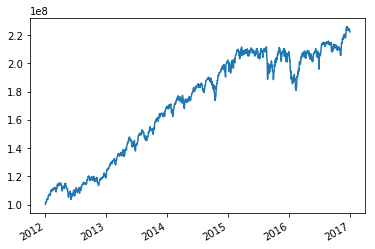

In [5]:
result_rank.v.plot()

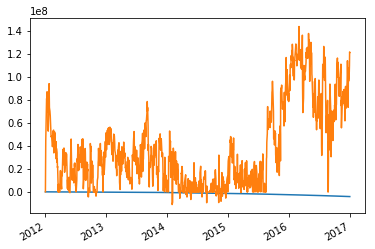

In [6]:
result_rank.h.USDOLLAR.plot()
result_spo.h.USDOLLAR.plot()

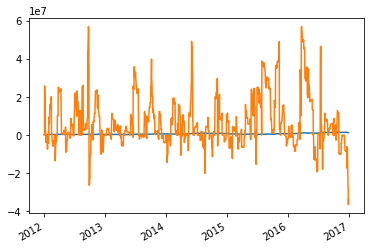

In [7]:
result_rank.h.AAPL.plot()
result_spo.h.AAPL.plot()

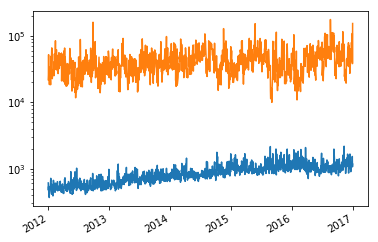

In [8]:
result_rank.simulator_TcostModel.sum(1).plot(logy=True)
result_spo.simulator_TcostModel.sum(1).plot(logy=True)



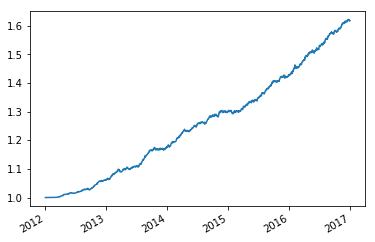

In [9]:
result_rank.leverage.plot()

In [10]:
# plt.figure(figsize=(8,5))
# for gamma_tcost in result_df_fine.columns[:]:
#     x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
#     y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
#     plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
# plt.legend(loc='lower right')
# plt.xlabel('Risk')
# plt.ylabel('Return')
# plt.xlim([0,20])
# plt.ylim([0,30])


# import matplotlib.ticker as mtick
# ax = plt.gca()
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

# plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

FileNotFoundError: [Errno 2] No such file or directory: '../../portfolio/plots/rank_vs_spo.png'

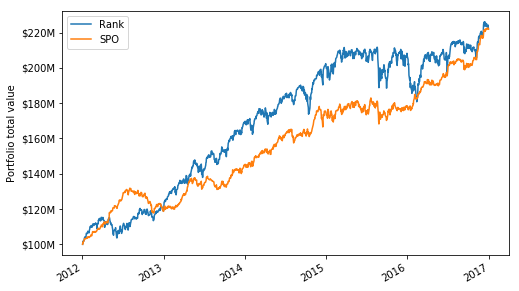

In [11]:
plt.figure(figsize=(8,5))
(result_rank.v/1E6).plot(label='Rank')
(result_spo.v/1E6).plot(label='SPO')
plt.legend()

import matplotlib.ticker as mtick
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%dM'))


plt.ylabel('Portfolio total value')
plt.savefig(plotdir+'rank_vs_spo.png')

In [ ]:
result_rank.leverage.plot(figsize=(12,6), label='Rank')
result_spo.leverage.plot(label='SPO')
plt.legend()
plt.ylabel('Leverage')

In [ ]:
np.abs(result_rank.u.iloc[10].sort_values()).plot(logy=True,  figsize=(8,8), label='rank, sample day')
np.abs(result_spo.u.iloc[10].sort_values()).plot(logy=True, label='spo, sample day')
plt.legend()
plt.ylabel('abs. val. trades vector')